# **Amazon Product Recommendation System**

In this project I will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model. 

--------------
## **Context**
--------------

E-commerce websites like Amazon, Flipkart use different recommendation models to provide personalized suggestions to different users. For example, one of the recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective**
----------------

Build a recommendation system to recommend products to customers based on their previous ratings for other products.

-----------------------------
## **Dataset** 
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [2]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095433 sha256=f068396d31b45aa7748bc7710aa3bf4f3a0c360a12da6efd0d1383974523f4db
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [5]:
# Suppress unnecessary warnings
import warnings                               
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np                             
import pandas as pd
from collections import defaultdict
from surprise.reader import Reader
from surprise.dataset import Dataset 
from surprise.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt                 
import seaborn as sns                           
%config InlineBackend.figure_formats = ['svg']

# Modeling
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import KFold
from surprise import CoClustering

# Hyperparameters tuning
from surprise.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import mean_squared_error  
from surprise import accuracy

### **Loading the data**

In [17]:
# Import the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Amazon Product Recommendation System/ratings_Electronics.csv',
                 header = None)

# Let's add column names
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] 

# Let's copy the data into another dataframe
df_copy = df.copy(deep = True)

# Let's drop timestamp as we will not time variation for this project 
# (coming in next commit)
df_copy = df_copy.drop('timestamp', axis = 1)

In [18]:
df_copy.shape

(7824482, 3)

**As this dataset is very large and has 7,824,482 observations, it is  computationally ineffective to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we will reduce the dataset by considering logical assumptions below.**

Here, I will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product. 

In [19]:
# Get the column containing the users
users = df_copy.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:        
        ratings_count[user] += 1
  
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [20]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

users_to_remove = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        users_to_remove.append(user)

df_copy = df_copy.loc[ ~ df_copy.user_id.isin(users_to_remove)]

In [24]:
df_copy.shape

(125871, 3)

In [21]:
# Get the column containing the products
prods = df_copy.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:
    
    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1
    
    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1    

In [22]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

users_to_remove = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        users_to_remove.append(user)

df_final = df_copy.loc[~ df_copy.prod_id.isin(users_to_remove)]

In [25]:
df_final.shape

(65290, 3)

In [27]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Data types**

In [29]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Observations:**
- We have 3 columns user_id and prod_id are of object type, rating is float64
- There is no missing values in the data, unless some of the ratings equal to 0.

Let's check it.

### **Checking for missing values**

In [30]:
(df_final['rating']==0).sum()

0

**Observations:**
- We can confirm that there is no missing values in the data.

### **Summary Statistics**

In [33]:
# Summary statistics of 'rating' variable and provide observations
df_final['rating'].describe()

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

**Observations:**
- The mean rating is 4.29, max rating is 5 and min rating is 1, not less than 50% of the ratings provided are 5. 
- From above we can conclude that most of the products rated very high. 
- There is no signs of outliers in the data. 

### **Checking the rating distribution**

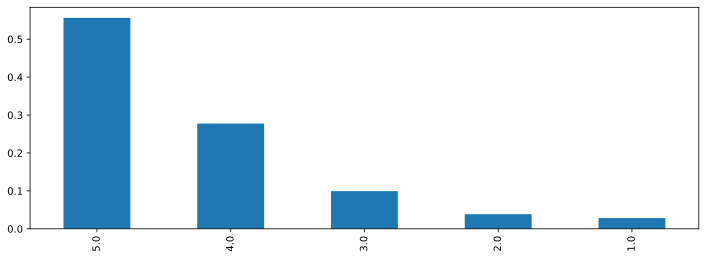

In [36]:
plt.figure(figsize = (12, 4))
df_final['rating'].value_counts(1).plot(kind = 'bar')
plt.show()

**Observations:**

- As we saw before we can conclude that more than 50% of the ratings are 5, ~ 30% of the ratings are 4 and the ratings 3, 2, 1 follow in decreasing manner. 

### **Checking the number of unique users and items in the dataset**

In [37]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df_final['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df_final['prod_id'].nunique())

Number of unique USERS in Raw data =  1540
Number of unique ITEMS in Raw data =  5689


- There are **1540 unique users and 5689 products** in the dataset. So there are 1540 x 5689 = 8 761 060 of possible interactions.
- Observed interactions are 65290/8761060 ~ 0.75% of the data. 

### **Users with the most number of ratings**

In [38]:
# Let's check top 10 users based on the number of ratings
most_rated = df_final.groupby('user_id').size().sort_values(ascending = False)[:10]
most_rated

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
dtype: int64

- The highest number of **ratings by a user is 295** which is far from the actual number of products present in the data.

## **Rank Based Recommendation System**

In [43]:
# Average rating for each product 
average_rating = df_final.groupby('prod_id').mean()['rating']

# Count of ratings for each product
count_rating = df_final.groupby('prod_id').count()['rating']

# Dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 
                             'rating_count':count_rating})

# Let's sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values('avg_rating',ascending=False)

final_rating.head()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [46]:
# Let's build a function to get the top n products based on the highest 
# average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):

    # Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count']>min_interaction]
    
    # Sorting values with respect to average rating 
    recommendations = recommendations.sort_values('avg_rating',ascending=False)
    
    return recommendations.index[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [48]:
list(top_n_products(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [49]:
list(top_n_products(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

## **Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

### **Terminology used:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating (here 3.5)** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold (here 3.5) is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**. 

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  

**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them. 


In [50]:
# Let's create a function to compute the above metrics
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # Mapping the predictions to each user
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions = model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. 
        # Therefore, we are setting Precision to 0 when n_rec_k is 0
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. 
        # Therefore, we are setting Recall to 0 when n_rel is 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    
    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    
    accuracy.rmse(predictions)
    print('Precision: ', precision) 
    print('Recall: ', recall)
    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3))

Let's load the `data` dataset into `surprise.dataset.DatasetAutoFolds` format which is required for this library.

In [52]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (1, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

Let's build a model using **KNNBasic** with cosine similarity. 

In [53]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

sim_user_user = KNNBasic(sim_options=sim_options,verbose=False,random_state=1)

# Fitting the model on the training data
sim_user_user.fit(trainset)

# Computing the metrics
precision_recall_at_k(sim_user_user)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


**Observations:**

- We got very decent performance with F1 Score on 10 products to recommend = 85.6%. 
- The precision and recall are very balanced.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Let's fine-tune the hyperparameters: 

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [55]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40,50,60],
              'min_k': [3, 6, 9, 12],
              'sim_options': {'name': ['msd', 'cosine', 'pearson','pearson_baseline'],
                              'user_based': [True]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9700137100943261
{'k': 60, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [56]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 60, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Computing the metrics with k =10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9526
Precision:  0.847
Recall:  0.894
F_1 score:  0.87


- We can observe that after tuning hyperparameters, F_1 score of the tuned model is 0.87, which is slightly better than the baseline model.
-  Along with this, the RMSE of the model has gone down as compared to the model before hyperparameter tuning. Hence, we can say that the model performance has improved slightly after hyperparameter tuning.

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Let's create an implementing function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [57]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')
    
    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)
    
    # Returing top n highest predicted rating products for this user
    return recommendations[:top_n] 

#### **Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [58]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_optimized)

In [59]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5
1,B000BQ7GW8,5
2,B001TH7GUU,5
3,B005ES0YYA,5
4,B00834SJSK,5


### **Correcting the Ratings and Ranking the above products**

While comparing the ratings of two products, it is not only the **ratings** that describe the **likelihood of the user to that product**. Along with the rating, the **number of users who have rated that product** also becomes important to consider. Due to this, we have calculated the **"corrected_ratings"** for each product. Commonly higher the **"rating_count" of a product more it is liked by users**. To interpret the above concept, a **product rated 4 with rating_count 3 is less liked in comparison to a product rated 3 with a rating count of 50**. It has been **empirically found that the likelihood of the item can be corrected by adding or subtracting the inverse of the square root of the rating_count of the product**.

In [63]:
# Let's create a function to correct predicted ratings
def ranking_products(recommendations, final_rating):
  # Sort the products based on ratings count
  ranked_products = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending = False)['rating_count'].reset_index()

  # Merge with the recommended products to get predicted ratings
  ranked_products = ranked_products.merge(pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings']), on = 'prod_id', how = 'inner')

  # Rank the products based on corrected ratings
  ranked_products['corrected_ratings'] = ranked_products['predicted_ratings'] - 1 / np.sqrt(ranked_products['rating_count'])

  # Sort the products based on corrected ratings
  ranked_products = ranked_products.sort_values('corrected_ratings', ascending = False)
  
  return ranked_products

**Note:** In the **above-corrected rating formula**, we can add the **quantity `1/np.sqrt(n)` instead of subtracting it to get more optimistic predictions**. But here we are **subtracting this quantity**, as there are some products with ratings 5 and **we can't have a rating more than 5 for a product**.

In [64]:
# Applying the ranking products function and sorting it based on corrected ratings
ranking_products(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,B00834SJSK,101,5,4.900496
1,B001TH7GUU,78,5,4.886772
2,B000BQ7GW8,54,5,4.863917
3,B000067RT6,41,5,4.843826
4,B005ES0YYA,26,5,4.803884


### Item-Item Similarity-based collaborative filtering recommendation systems

Let's try item-item similarity approach. 

In [65]:
# Similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Trainning the algorithm on the trainset
sim_item_item.fit(trainset)

# Let's compute the metrics with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


- The baseline model is giving a good F_1 score of 84.1%.
- Let's try to improve it by fine-tuning hyperparameters. 


#### Improving similarity-based recommendation system by tuning its hyperparameters

In [68]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40,50,60],
              'min_k': [3, 6, 9, 12],
              'sim_options': {'name': ['msd', 'cosine', 'pearson','pearson_baseline'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'],cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9747798422721856
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Now let's build the **final model** using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

In [69]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd', 'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(k=30, 
                                   min_k=6,
                                   sim_options=sim_options,
                                   random_state = 1, 
                                   verbose = False)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let's compute the metrics with k = 10
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9576
Precision:  0.839
Recall:  0.88
F_1 score:  0.859


**Observations:**
- We managed to substantially improve the model performance.
- All the metrics improved except for Precision which is the same. 
- The performance achieved on user-user approach than on item-item. 

#### Predicted top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.

In [70]:
# Making top 5 recommendations for the user_id A1A5KUIIIHFF4U
# with recommendation engine built
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)

In [71]:
# Building the dataframe for above recommendations
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


In [72]:
# Applying the ranking products function and sorting it based on the corrected ratings 
ranking_products(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,9983891212,8,4.292024,3.938471
1,B00000J1V5,7,4.292024,3.914060
2,1400532655,6,4.292024,3.883776
3,1400599997,5,4.292024,3.844810
4,B00000DM9W,5,4.292024,3.844810


**Let's try model-based Collaborative Filtering.**

### Model-Based Collaborative Filtering - Matrix Factorization

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We will use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

In [73]:
# Using SVD matrix factorization
svd = SVD(random_state=1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Let's compute the metrics with k = 10
precision_recall_at_k(svd)

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


**Observations:**

- We achieved quite decent model performance which is higher than performance achieved on item-item collaborative filtering and slightly lower than performance achieved on user-user collaborative filtering.
- Precision and Recall are quite balanced.  

#### Improving matrix factorization based recommendation system by tuning its hyperparameters

In SVD, rating is predicted as: 

$$\hat{r}_{u i}=\mu+b_{u}+b_{i}+q_{i}^{T} p_{u}$$

If user $u$ is unknown, then the bias $b_{u}$ and the factors $p_{u}$ are assumed to be zero. The same applies for item $i$ with $b_{i}$ and $q_{i}$.

To estimate all the unknown, we minimize the following regularized squared error:

$$\sum_{r_{u i} \in R_{\text {train }}}\left(r_{u i}-\hat{r}_{u i}\right)^{2}+\lambda\left(b_{i}^{2}+b_{u}^{2}+\left\|q_{i}\right\|^{2}+\left\|p_{u}\right\|^{2}\right)$$

The minimization is performed by a very straightforward **stochastic gradient descent**:

$$\begin{aligned} b_{u} & \leftarrow b_{u}+\gamma\left(e_{u i}-\lambda b_{u}\right) \\ b_{i} & \leftarrow b_{i}+\gamma\left(e_{u i}-\lambda b_{i}\right) \\ p_{u} & \leftarrow p_{u}+\gamma\left(e_{u i} \cdot q_{i}-\lambda p_{u}\right) \\ q_{i} & \leftarrow q_{i}+\gamma\left(e_{u i} \cdot p_{u}-\lambda q_{i}\right) \end{aligned}$$

Let's try to fine-tune these hyperparameters:

- **n_factors**: The number of factors used for SVD
- **biased (bool)**: Whether to use baselines (or biases).
- **n_epochs**: The number of iteration of the SGD algorithm
- **lr_all**: The learning rate for all parameters
- **reg_all**: The regularization term for all parameters

In [74]:
# Set the parameter space to tune
param_grid = {'n_factors' : [80,90,100,120,140,160,180,200],
              'biased' : [True,False],
              'n_epochs': [10,20,30],
              'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs_ = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs_.fit(data)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.8985033727609687
{'n_factors': 100, 'biased': True, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, let's build **the final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [75]:
# Building the optimized SVD model using optimal hyperparameter search
svd_optimized = SVD(n_factors=100, 
                    biased=True,
                    n_epochs=20,
                    lr_all=0.01,
                    reg_all=0.2,
                    random_state=1)

# Train the algorithm on the trainset
svd_optimized.fit(trainset)

# Let's compute the metrics with k = 10
precision_recall_at_k(svd_optimized)

RMSE: 0.8808
Precision:  0.854
Recall:  0.878
F_1 score:  0.866


**Observations:**
- The model performance is just marginally better then the performance achieved on base model.  

In [76]:
# Making top 5 recommendations for the user_id A2XIOXRRYX0KZY
# with recommendation engine built
recommendations = get_recommendations(df_final, "A2XIOXRRYX0KZY", 5, svd_optimized)

In [77]:
# Building the dataframe for above recommendations
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000JV9LUK,4.888310
1,B0010Y414Q,4.860932
2,B00AR95ESC,4.858811
3,B00IVPU6AA,4.851976
4,B005PQTYHE,4.842736


In [78]:
# Applying the ranking products function and sorting it based on the corrected ratings 
ranking_products(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,B00IVPU6AA,14,4.851976,4.584715
2,B000JV9LUK,10,4.888310,4.572082
1,B0010Y414Q,11,4.860932,4.559421
3,B00AR95ESC,9,4.858811,4.525478
4,B005PQTYHE,7,4.842736,4.464772


## **Conclusions**:


- The best performance was achieved with optimised KNNBasic model based on user-user similarities, F1 Score = 87%
- Matrix Factorization has lower RMSE with SVD approach (0.8808 vs 0.9526) because this method assumes that both products and users are present in some low dimensional latent space describing their properties and recommends a product based on its proximity to the user in the latent space.
- We recommend to use optimised KNNBasic model at this stage as it gives the best results. 

## **Next Steps**:
We propose to:

 -  Consider hybrid recommendation system as it has potential to push the performance even further.
 - Incorporate time-based approach.  